Conclusion:

At 17 components, we we're still able to achieve ~94% accuracy. We could probably drop down to 12-15 components and still achieve ~90% accuracy. (We won't do this though, since this last box of code took >10 minutes to run.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Building a random forest to predict the state of a loan given some information about it.

In [2]:
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

C:\Users\starr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [4]:
#look at categorical variables and see how many distinct counts there are
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical [i]
    print(i)
    print(column.nunique)

id
<bound method IndexOpsMixin.nunique of 0                                                 68009401
1                                                 68354783
2                                                 68466916
3                                                 68466961
4                                                 68495092
5                                                 68506798
6                                                 68566886
7                                                 68577849
8                                                 66310712
9                                                 68476807
10                                                68341763
11                                                68356421
12                                                68426545
13                                                68407277
14                                                68355089
15                                                68466926
16            

Big problem. Some have over a hundred thousand distinct types. We'll drop the ones that have over 30 unique values, converting to numeric where that makes sense.

In [5]:
#convert ID and interest rate to numeric
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

#drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [6]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#remove two summary rows that contain no data
y2015 = y2015[:-2]

In [8]:
#use pd.get_dummies to convert categorical variables into dummy/indicator variables
pd.get_dummies(y2015);

In [9]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.97917409, 0.98036143, 0.98152502, 0.98188122, 0.97513655,
       0.97800997, 0.97081384, 0.98088295, 0.97895837, 0.97969411])

Score cross validation reports the accuracy of the tree. ~98% accurate.

This worked well but has potential problems. We didn't do much of anything with feature selection or model refinement (thus, a large number of features we don't need). Also, there can be some variance in scores. This could be corrected by increasing the number of estimators (would probably make it take too long to run.)

DRILL: Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation. (Use PCA.)

In [10]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

#normalize the data
X = StandardScaler().fit_transform(X)

#transpose X, since NumPY assumes variables are represented in rows
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00000237e+00  9.97542503e-01 -8.28800909e-03 ...  3.16988700e-02
   1.52046554e-02  2.45114833e-02]
 [ 9.97542503e-01  1.00000237e+00 -8.61952110e-03 ...  3.20023212e-02
   1.53795433e-02  2.47610695e-02]
 [-8.28800909e-03 -8.61952110e-03  1.00000237e+00 ...  8.35951079e-03
   7.08866573e-03  1.43504240e-02]
 ...
 [ 3.16988700e-02  3.20023212e-02  8.35951079e-03 ...  1.00000237e+00
  -3.12145102e-04 -5.16540667e-04]
 [ 1.52046554e-02  1.53795433e-02  7.08866573e-03 ... -3.12145102e-04
   1.00000237e+00 -2.39751698e-04]
 [ 2.45114833e-02  2.47610695e-02  1.43504240e-02 ... -5.16540667e-04
  -2.39751698e-04  1.00000237e+00]]


In [11]:
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

C:\Users\starr\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


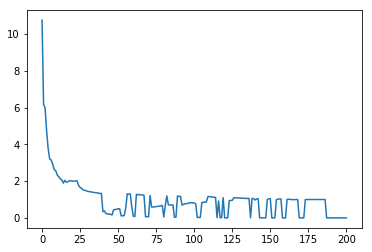

In [12]:
#create scree plot to determine which components best describe the variance
plt.plot(eig_val_cov)
plt.show()

It appears that the first 17 or so components are the most important.

In [14]:
X = y2015.drop('loan_status', 1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)
pca = PCA(n_components=17)
X = pca.fit_transform(X)
Y = y2015['loan_status']

cross_val_score(rfc, X, Y, cv=10)

array([0.79969604, 0.94922942, 0.94922942, 0.95312389, 0.95863215,
       0.94507243, 0.95359662, 0.95129307, 0.95642055, 0.92746877])